# Binary Stars and Markov Chain Monte Carlo: How They Fit Together
## Tony Rodríguez
## Physics 166, Winter 2019
### Due 22 March 2019

## 1. Bayesian Inference

* Recall Bayes' Theorem:
$P(X|Y,I) = \frac{P(Y|X,I)P(X|I)}{P(Y|I)}$

* Set to a proportionality in our language: $\Pi(\theta|\underline{x}) \propto L(\underline{x}|\theta)\Pi(\theta)$

* All this says is that "posterior" is proportional to "likelihood" times "prior"

* In the Bayesian interpretation, the parameters $\theta$, are random variables, so they follow Kolmogorov's Axioms.

* $P(\theta_1 \leq \theta \leq \theta_2)$ is a well-defined measure of the **degree of belief** that the parameter $\theta$ is in a certain range.

* And now everything is just a conditional probability $\rightarrow$ *no need for statistics*...

## 2. Markov Chain Monte Carlo (MCMC)

### i. Why do we need it?

* We've done Monte Carlo rejection sampling in this class already:

In [85]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

Defining the equations of the circle that serve as the bounds for the Monte Carlo simulation:

In [86]:
N = 5000

def some_pdf(x):
    return np.sqrt(1 - x**2)

def new_pdf(x):
    return -some_pdf(x)

Discarding the points outside the circle, keeping the ones inside:

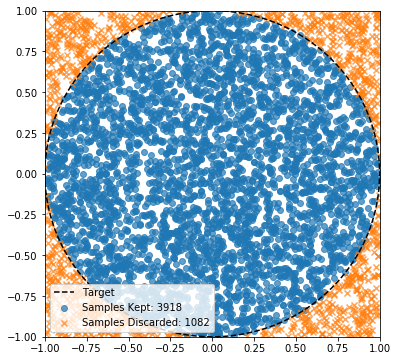

Estimate of pi = 3.1344


In [87]:
x_range = np.linspace(-1, 1, 1000)

x_gen = 2*np.random.random_sample(N) -1
u_gen = 2*np.random.random_sample(N) -1

ind_disc = u_gen > some_pdf(x_gen)
ind_disc += u_gen < -some_pdf(x_gen)

x_disc = x_gen[ind_disc]
u_disc = u_gen[ind_disc]
x_keep = x_gen[~ind_disc]
u_keep = u_gen[~ind_disc]

fig = plt.figure(figsize=(6,6))
plt.scatter(x_keep, u_keep, marker='o', alpha=0.7, label="Samples Kept: " + str(len(x_keep)))
plt.scatter(x_disc, u_disc, marker='x', alpha=0.7, label="Samples Discarded: "+ str(len(x_disc)))
plt.plot(x_range, some_pdf(x_range), '--', c='k', label="Target")
plt.plot(x_range, -some_pdf(x_range), '--', c='k')
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.legend(framealpha=0.8, loc="lower left")
plt.show()
fig.savefig("circleMC.png")
print('Estimate of pi = ' + str(4*len(x_keep)/N))

All the circle was doing was specifying some pdf. In section we saw this the rejection sampling for an actual pdf, but was inefficient due to the number of samples discarded:

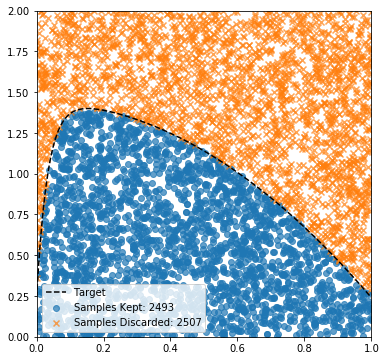

In [88]:
N = 5000

def some_pdf(x):
    return(1/0.833333)*(-x**2 - np.exp(-30*x) + 1.2)

x_range = np.linspace(0, 1, 1000)

x_gen = np.random.random_sample(N)
u_gen = 2*np.random.random_sample(N)

ind_disc = u_gen > some_pdf(x_gen)


x_disc = x_gen[ind_disc]
u_disc = u_gen[ind_disc]
x_keep = x_gen[~ind_disc]
u_keep = u_gen[~ind_disc]

fig = plt.figure(figsize=(6,6))
plt.scatter(x_keep, u_keep, marker='o', alpha=0.7, label="Samples Kept: " + str(len(x_keep)))
plt.scatter(x_disc, u_disc, marker='x', alpha=0.7, label="Samples Discarded: "+ str(len(x_disc)))
plt.plot(x_range, some_pdf(x_range), '--', c='k', label="Target")
plt.xlim([0, 1])
plt.ylim([0, 2])
plt.legend(framealpha=0.8, loc="lower left")
plt.savefig("pdfMC.png")
plt.show()

* I already knew the shape of the pdf, but if I didn't know, then where would I sample?
* MCMC takes care of this by being a type of **importance sampling**.

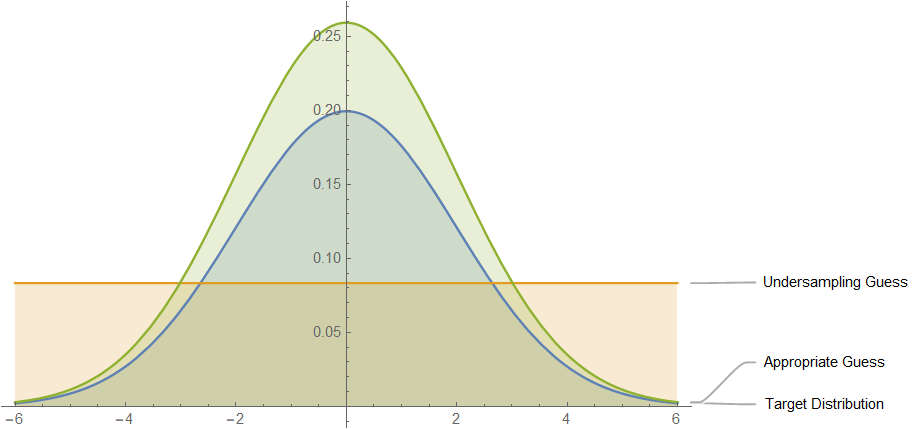

In [210]:
Image("ImportSampling.png", width=600, height=600)

* Trying to do this in **high-dimensional paramter space** would be **absolute madness!**
* MCMC fixes this by using the concept of Markov chains when performing the Monte Carlo trials.

### ii. What is MCMC?

* A type of importance sampling, where there is some unknown pdf of parameters, given the data: $\Pi(\theta|\underline{x})$

* MCMC **provides an efficient and easy way to sample points from the distribution which is analogous to evaluating the distribution** (Sharma 2017)

* For multi-parameter models, MCMC is able to efficiently explore the parameter space to obtain the underlying distribution.

#### MCMC uses a Markov chain: $P(X_{n+1}=x|X_1=x_1, X_2=x_2, \dots, X_n=x_n) = P(X_{n+1}=x|X_n = x_n)$

* This means that your next "move" is based only on your current state and doesn't care about what you've done in the past (if anything at all)
* Will lead to one of two caveats that we must take into account...

The simplest example is the **Metropolis-Hastings algorithm** (1953) *Note*: MCMC has been around for a while, it has just taken computers a while to step up.

This works as follows:
After generating a set of samples, the most recent of which is $\theta_k$:
1. Draw a proposal $\theta'$ from the proposal distribution $q(\theta'|\theta_k)$
2. Draw a random number $0 < r < 1$ from the uniform distribution
3. If $f(\theta')/f(\theta_k) > r$, then take $\theta'$ as $\theta_{k+1}$. Otherwise, take $\theta_k$ as $\theta_{k+1}$

This can lead to two possible issues: **autocorrelation** and a period of time called the **"burn-in" period**. The former results from the quite obvious fact that nearby samples are not independent. However, in the limit of arbitrary run time, this algorithm does produce "fair" samples (Hogg and Foreman-Mackey 2018). The latter is simply a period of time where parameter space is being explored that eventually will reveal to not be near the most likely part of the distribution. A lot of MCMC packages have the option to remove samples from this period of time entirely. 

This is a [video of M-H MCMC in action](https://www.youtube.com/watch?v=OTO1DygELpY&t=429s). Start at 3:30.

### iii. A Toy Example

In a toy example, I'll start by only fitting a non-linear model of two parameters. Consider a (freshman physics or even high-school lab course) example for measuring total energy: $E = \frac{1}{2}m v^2 + E_0$. I control $v$ very well, but I measure $E$ with Gaussian errors. How do I find $m$ and $E_0$? Take $a \equiv \frac{1}{2}m$ and $b \equiv E_0$:

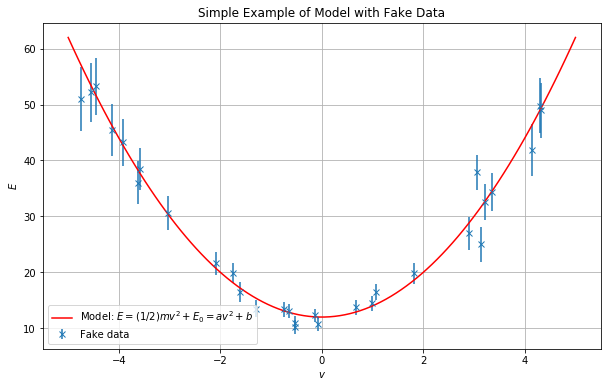

In [89]:
import numpy as np

# Choose the "true" parameters.
a_true = 2.0
b_true = 12.0

# Generate some synthetic data from the model.
N = 30
x = np.sort(10*np.random.rand(N) - 5)
y = a_true*x**2 +b_true
yerr = 0.1*y

# Try this as well:
# yerr = 4

# For good resolution when plotting regardless of N
x_plot = np.linspace(-5,5,100)
def y_plot(xvals): return a_true * (xvals)**2 + b_true

fig = plt.figure(figsize=(10,6))
y_meas = y + yerr * np.random.normal(size=N)
plt.errorbar(x, y_meas, yerr=yerr, marker='x', linestyle='', label='Fake data')
plt.plot(x_plot, y_plot(x_plot), 'r-', label='Model: $E = (1/2)mv^2 + E_0 = a v^2 + b$')
plt.grid(True)
plt.xlabel('$v$')
plt.ylabel('$E$')
plt.title('Simple Example of Model with Fake Data')
plt.legend(framealpha=0.8, loc="lower left")
plt.savefig('toyPDF.png')
plt.show()

Writing the Gaussian likelihood function. Recall the Bayesian framework: $\Pi(\theta|\underline{x}) \propto L(\underline{x}|\theta)\Pi(\theta)$

Here, I am setting $L(\underline{x}|\theta) = \prod^n_{i=1} \dfrac{1}{\sigma_i\sqrt{2\pi}}\exp\Big[-\dfrac{1}{2}\Big(\frac{y_i - (ax_i^2 + b)}{\sigma_i}\Big)^2\Big]$

Note that $\sigma_i$ refers to errors in $y_i$ (there are no errors in $x_i$)

Doing this in terms of log-likelihood, log-prior, log-posterior is much easier:
$\ln L(\underline{x}|\underline{\theta}) = \sum_{i=1}^n\Bigg[\ln\Big(\dfrac{1}{\sigma_i\sqrt{2\pi}}\Big) -\dfrac{1}{2} \Big(\frac{y_i - (ax_i^2 + b)}{\sigma_i}\Big)^2\Bigg]$

In [90]:
def lnlike(theta, x, y, yerr):
    a, b = theta
    model = a * (x**2) + b
    inv_sig = 1/yerr
    return np.sum(np.log((1/np.sqrt(2*np.pi))*inv_sig) - 0.5*((y - model)*inv_sig)**2)

Setting uniform priors (we'll choose different ranges later, but let's try these for now):

In [91]:
def lnprior(theta):
    a, b = theta
    if 0.0 < a < 10.0 and 5.0 < b < 30.0:
        return 0.0
    return -np.inf

And our log-prior is easy! Just sum the log-prior and log-likelihood -- that's what makes Bayesian inference so great!

In [92]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

The number of dimensions of parameter space is 2, and I'll start 100 "walkers" to explore the parameter space. Maybe this experiment has already been done before and I have some idea of what the parameters could be, so I'll start the walkers there.

In [93]:
ndim, nwalkers = 2, 100
a_start = 4.0
b_start = 6.0
start = np.array((a_start, b_start))
pos = [start + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [94]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y_meas, yerr))
sampler.run_mcmc(pos, 1000)

(array([[ 1.83897261, 12.53597817],
        [ 1.9509704 , 11.39971299],
        [ 1.81437529, 12.08656311],
        [ 2.04081154, 11.28980473],
        [ 1.97874112, 12.23078098],
        [ 1.95629796, 11.46945034],
        [ 1.95897012, 11.49292415],
        [ 1.90416915, 11.55114256],
        [ 1.98459361, 12.19869135],
        [ 1.97523904, 11.68206738],
        [ 2.01948396, 11.45810229],
        [ 2.09718895, 11.00939479],
        [ 1.99956157, 11.52817779],
        [ 1.88572704, 12.02652729],
        [ 1.9486659 , 12.08166736],
        [ 1.84591943, 12.05690379],
        [ 1.95604289, 12.11964931],
        [ 2.12935966, 11.59763191],
        [ 1.96702803, 12.32574048],
        [ 1.90245732, 12.41722454],
        [ 1.93499723, 11.85609614],
        [ 2.01373012, 11.58270047],
        [ 2.00213127, 11.44298223],
        [ 2.00224516, 11.36300792],
        [ 2.02959162, 11.46060421],
        [ 2.01128842, 12.29862874],
        [ 1.96341416, 11.99538371],
        [ 1.93652614, 11.726

Let's visualize where in parameter space the "walkers" have explored:

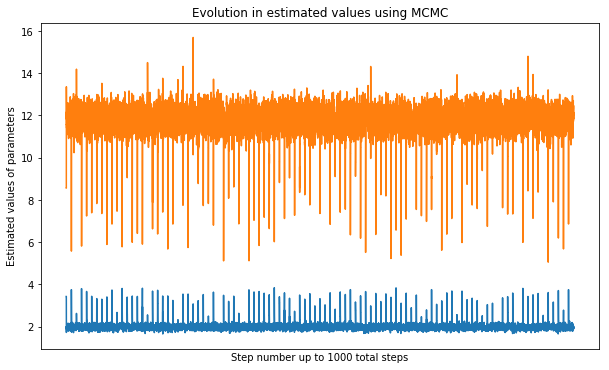

In [95]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
fig = plt.figure(figsize=(10,6))
plt.plot(samples)
plt.xlabel('Step number up to 1000 total steps')
plt.ylabel('Estimated values of parameters')
plt.title('Evolution in estimated values using MCMC')
plt.xticks([])
plt.show()

Time for corner plots! The true values are in blue:

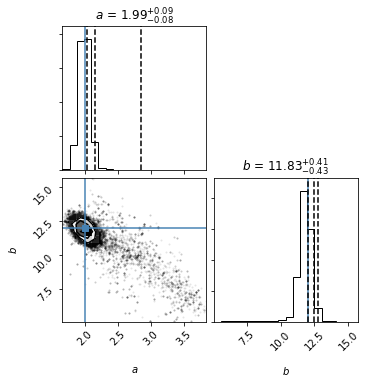

In [96]:
import corner
fig = corner.corner(samples, labels=[r"$a$", r"$b$", r"$\Gamma \, [\mathrm{parsec}]$"],
                       quantiles=[0.68, 0.95, 0.99],
                       show_titles=True, title_kwargs={"fontsize": 12}, truths=[a_true, b_true])
fig.savefig("triangleToy.png")
fig.show()

## 3. Binary Star Project

### i. Background

**MCMC is meant to be used when your model is very well-known**, like in astrophysics! The orbit of a binary star system is really just Newtonian mechanics, so the underlying processes are known extremely well.

*I'm referring to your run-of-the-mill binary system, no neutron star binaries where we need General Relativity, no black-widow systems with a pulsar heating a companion and causing interesting physics to emerge... we will be dealing with a simple case here!*

There is just one equation we will use: $P^2 = \dfrac{4\pi^2 a^3}{G(m_1 + m_2)}$ -- Kepler's Third Law!

We are looking for nine orbital parameters here:
* $a, e$ are related to the shape of the orbit.
* $i, \Omega, \omega$ are the Euler angles corresponding to the angle at which we are viewing the orbit from Earth.
* $T_0$ is a reference time when one of the stars passes through periastron (closest to other star).
* $m_1, m_2$ are the masses each star.
* $RV_0$ is the rotational velocity of the system. 

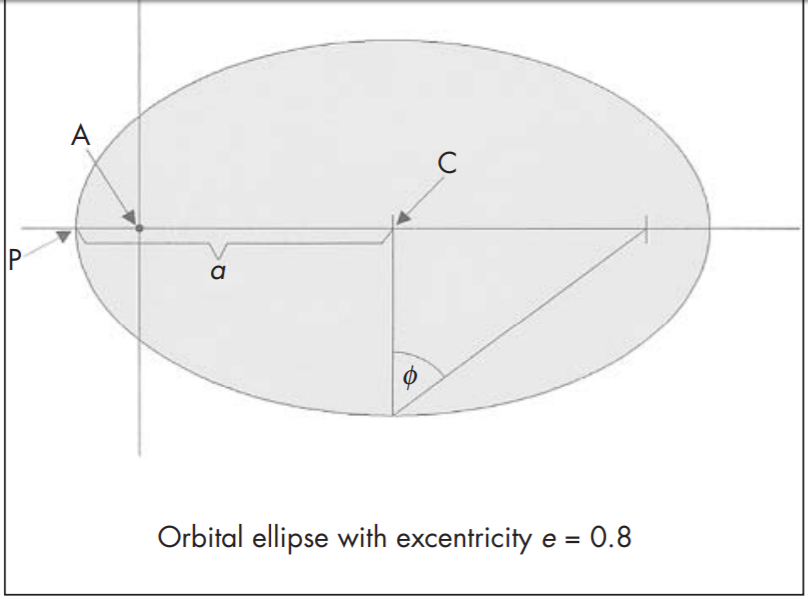

In [319]:
Image("Orbital Elements 2.PNG", width=600, height=600)

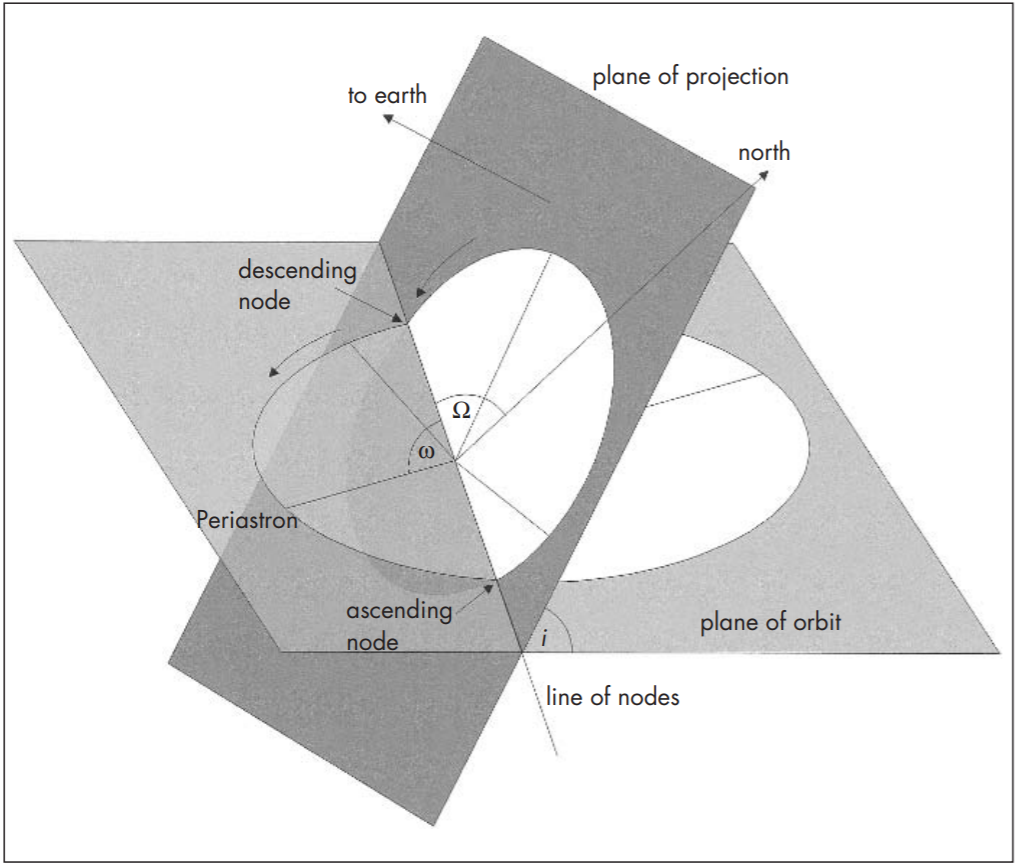

In [320]:
Image("Orbital Elements.PNG", width=600, height=600)

It's impressive how far basic algebra and trigonometry can go regarding orbital mechanics. Actually implementing this requires a series of nested equations, one of which must be solved numerically using the Newton-Raphson method. I'll omit them here, but I'll include the most relevant ones:

$RV = K[\cos(\omega + \nu) + e\cos\omega] + RV_0$

$\rho = \sqrt{\Delta RA^2 + \Delta DEC^2}$

$\theta = \arctan(\Delta RA / \Delta DEC)$

**For the full equations, see the final report. There were some mistakes in the original problem description that I helped Eric find.**

### ii. Implementation

Here's the data, provided by Dr. Eric Nielsen:

In [28]:
RV_data = np.array((2.2, 2.9, 5.05, 5.4, 5.6, -1.53,
                   2.15, 2.53, 2.52, 2.55, 2.50,
                   2.75, 2.70, 4.40, 4.50, 4.29,
                   4.35, 4.51, 4.15, 4.46, 4.53,
                   1.75, 5.31, 5.5, 0.63, 5.57, 
                   5.49, 5.57, 5.41, 5.39, 5.97, 
                   5.61, 5.3, 5.33, 5.12, 4.97, 
                   4.8, 4.66, 4.92, 4.91))
RV_data_err = np.array((1.2, 2.2, 0.16, 0.7, 0.4, 0.16,
                   0.16, 0.16, 0.13, 0.13, 0.13,
                   0.13, 0.13, 0.13, 0.13, 0.13,
                   0.13, 0.13, 0.13, 0.13, 0.13,
                   0.13, 0.16, 0.3, 1.0, 0.16, 
                   0.16, 0.16, 0.16, 0.16, 0.16, 
                   0.16, 0.16, 0.16, 0.16, 0.16, 
                   0.16, 0.16, 0.16, 0.16))
dates_RV = np.array(((2001,4,6), (2001, 6,2), (2002, 4, 4), 
                    (2002, 7, 25), (2003, 3, 27), (2004, 4, 4),
                    (2005, 2, 19), (2005, 3, 23), (2005, 4, 1),
                    (2005, 4, 5), (2005, 4, 7), (2005, 5, 9),
                    (2005, 5, 31), (2006, 3, 11), (2006, 4, 2),
                    (2006, 4, 3), (2006, 5, 5), (2006, 5, 18),
                    (2006, 5, 22), (2006, 5, 24), (2006, 6, 10),
                    (2009, 7, 20), (2007, 5, 2), (2007, 5, 6),
                    (2009, 3, 16), (2012, 3,5),(2012, 4, 14), (2012, 4, 15),
                    (2012, 4, 16), (2012, 4, 16), (2012, 4, 18),
                    (2012, 4, 22), (2012, 4, 23), (2012, 4, 26),
                    (2012, 6, 3), (2012, 6, 3), (2012, 6, 10),
                    (2012, 6, 10), (2012, 6, 13), (2012, 6, 13)
                    ))
dates_sep_pos = np.array(((2003, 2, 19), (2009, 9, 30), (2011, 3, 25),
                         (2015, 7, 3), (2016, 3, 21), (2016, 4, 30),
                         (2016, 4, 30)))
sep_dat = np.array((63.2, 68, 98.6, 111.3, 103.2, 100.5, 102.3))
sep_err = np.array((6.8, 6.6, 4.6, 21.3, 4.3, 3.2, 3.3))
pos_dat = np.array((54.6, 333.6, 32.6, 21.6, 35.8, 39.2, 40.4))
pos_err = np.array((4.1, 3.0, 3.5, 5.0, 1.6, 1.3, 1.2))


Preparing the data for processing:

In [29]:
# This is an approximation, I think. Good enough...
def toDecimalYear(date):
    yr, mon, day = date
    if mon == 1 or mon == 3 or mon == 5 or mon == 7\
    or mon == 8 or mon == 10 or mon == 12:
        return yr + (mon-1)/12 + ((day-1)/31)/12
    if mon == 4 or mon == 6 or mon == 9 or mon == 11:
        return yr + (mon-1)/12 + ((day-1)/30)/12
    if mon == 2:
        return yr + (mon-1)/12 + ((day-1)/28)/12
    
    
dates_RV_new = np.zeros(len(dates_RV))
for i in range(len(dates_RV)):
    dates_RV_new[i] = toDecimalYear(dates_RV[i])
    
dates_sep_pos_new = np.zeros(len(dates_sep_pos))
for i in range(len(dates_sep_pos)):
    dates_sep_pos_new[i] = toDecimalYear(dates_sep_pos[i])
    

In [30]:
# Final labels:
DIST = 38.5
t_rv = dates_RV_new
t_sep = dates_sep_pos_new
t_pos = t_sep

rv_dat = RV_data 
rv_err = RV_data_err 

# Converting to AU from milliarcseconds
sep_dat = sep_dat *1e-3 *DIST 
sep_err = sep_err *1e-3 * DIST 

# Taking the position angles in radians, along with the errors
pos_dat = np.radians(pos_dat)
pos_err = np.radians(pos_err)

Just to remind myself once more of the framework: $\Pi(\theta|\underline{x}) \propto L(\underline{x}|\theta)\Pi(\theta)$

Here, I am setting $L(\underline{x}|\underline{\theta}) = \prod^n_{i=1} \dfrac{1}{\sigma_i\sqrt{2\pi}}\exp\Big[-\dfrac{1}{2}\Big(\frac{y_i - f(\underline{x}|\underline{\theta})}{\sigma_i}\Big)^2\Big]$

Doing this in terms of log-likelihood, log-prior, log-posterior is much easier:
$\ln L(\underline{x}|\underline{\theta}) = \sum_{i=1}^n\Bigg[\ln\Big(\dfrac{1}{\sigma_i\sqrt{2\pi}}\Big) -\dfrac{1}{2} \Big(\frac{y_i - f(\underline{x}|\theta)}{\sigma_i}\Big)^2\Bigg]$

Can be reduced to: $\ln L(\underline{x}|\underline{\theta}) = \sum_{i=1}^n\Bigg[ -\dfrac{1}{2} \Big(\frac{y_i - f(\underline{x}|\theta)}{\sigma_i}\Big)^2\Bigg]$

But I now have nine parameters: $a, e, i, \Omega, \omega, T_0, m_1, m_2, RV_0$

The problem is manageable through a series of nested functions:

In [32]:
from scipy import optimize

There's one equation (Kepler's equation) that I need to solve numerically. All others are defined explicitly and I can just plug them into the model.

In [33]:
# And setting G for working in years and AU's
G = 4*np.pi**2

# Making sure to convert from AU / yr to km / s !!
SCALE = 1.496e8 / 3.174e7
print(SCALE)

4.7132955261499685


## THE "wrap" VARIABLES ARE CRUCIAL. They ensure that the anomlaies (mean, eccentric, true), which are all really just angles, are kept in the same range. 

To check, just plot! Instead of having rv_model return $RV$, you can make it return any of the parameters or intermediate values to do a quick check of the wrapping. But the code is correct as it currently stands. 

In [35]:
# Making sure to convert from AU / yr to km / s !!
def K(m_t, m_2, inc, P, e):
    term1 = (m_2/(m_t-m_2))*np.sin(inc) * SCALE
    term2 = (2*np.pi*G*(m_t-m_2)/P)**(1/3)
    term3 = (1-e**2)**(-1/2)
    term4 = (1 + m_2/(m_t-m_2))**(-2/3)
    return term1*term2*term3*term4

def nu(e, E):
    return 2*np.arctan2(np.sqrt(1+e)*np.tan(E/2),np.sqrt(1-e))

def E(e, M):
    def func(sol):
        return sol - M - e*np.sin(sol)
    # Setting the guess to be M
    return optimize.newton(func, M)

def M(time, T_0, P):
    return 2*np.pi*(time - T_0)/P

def P(a, m_t):
    return np.sqrt((a**3)/m_t)


def rv_model(x, theta):
    t = x
    a, e, inc, O, w, T_0, m_t, m_2, RV_0 = theta
    M_wrap = M(t, T_0, P(a, m_t)) % (2*np.pi)
    E_wrap = E(e, M_wrap)
    if E_wrap > np.pi: E_wrap = E_wrap - 2*np.pi
    nu_wrap = nu(e, E_wrap)
    K_fin = K(m_t, m_2, inc, P(a, m_t), e)
    
    return K_fin*(np.cos(w + nu_wrap) + e*np.cos(w)) + RV_0

In [36]:
def deltRA(a, e, nu, inc, O, w):
    term1i = a*(1-e**2)/(1 + e*np.cos(nu))
    term2ai = np.cos(nu)*np.cos(inc)*np.cos(O)*np.sin(w)
    term2bi = np.cos(nu)*np.sin(O)*np.cos(w)
    term2ci = np.sin(nu)*np.cos(inc)*np.cos(O)*np.cos(w)
    term2di = np.sin(nu)*np.sin(O)*np.sin(w)
    return term1i*(term2ai + term2bi + term2ci - term2di)

def deltDEC(a, e, nu, inc, O, w):
    term1ii = a*(1-e**2)/(1 + e*np.cos(nu))
    term2aii = np.cos(nu)*np.cos(inc)*np.sin(O)*np.sin(w)
    term2bii = np.cos(nu)*np.cos(O)*np.cos(w)
    term2cii = np.sin(nu)*np.cos(inc)*np.sin(O)*np.cos(w)
    term2dii = np.sin(nu)*np.cos(O)*np.sin(w)
    return term1ii*(-term2aii + term2bii - term2cii - term2dii)

def sep_model(x, theta):
    t = x
    a, e, inc, O, w, T_0, m_t, m_2, RV_0 = theta
    
    M_wrap = M(t, T_0, P(a, m_t)) % (2*np.pi)
    E_wrap = E(e, M_wrap)
    if E_wrap > np.pi: E_wrap = E_wrap - 2*np.pi
    nu_wrap = nu(e, E_wrap)
    
    term1iii = deltRA(a, e, nu_wrap,
                   inc, O, w)
    term2iii = deltDEC(a, e, nu_wrap,
                   inc, O, w)
    return np.sqrt(term1iii**2 + term2iii**2) 

def pos_model(x, theta):
    t = x
    a, e, inc, O, w, T_0, m_t, m_2, RV_0 = theta
    
    M_wrap = M(t, T_0, P(a, m_t)) % (2*np.pi)
    E_wrap = E(e, M_wrap)
    if E_wrap > np.pi: E_wrap = E_wrap - 2*np.pi
    nu_wrap = nu(e, E_wrap)
    
    term1iv = deltRA(a, e, nu_wrap,
                   inc, O, w)
    term2iv = deltDEC(a, e, nu_wrap,
                   inc, O, w)
    fin = np.arctan2(term1iv, term2iv)
    if fin < 0:fin +=  2*np.pi
    return fin
    

Wrapping it all up into a single log-likelihood function:

In [37]:
def lnlike(theta, x, y, yerr):
    rv, sep, pos = y
    rv_err, sep_err, pos_err = yerr
    t_rv, t_sep, t_pos= x
    
    mod_rv = np.zeros(len(rv))
    mod_sep = np.zeros(len(sep))
    mod_pos = np.zeros(len(pos))
    
    for i in range(len(mod_rv)):
        mod_rv[i] = rv_model(t_rv[i], theta)
    for i in range(len(mod_sep)):
        mod_sep[i] = sep_model(t_sep[i], theta)
    for i in range(len(mod_pos)):
        mod_pos[i] = pos_model(t_pos[i], theta)
        
    inv_sig_rv = 1/rv_err
    inv_sig_sep = 1/sep_err
    inv_sig_pos = 1/pos_err
    
    
    term1 = np.sum(- 0.5*((rv - mod_rv)*inv_sig_rv)**2)
    term2 = np.sum( - 0.5*((sep - mod_sep)*inv_sig_sep)**2)
    term3 = np.sum(- 0.5*((pos - mod_pos)*inv_sig_pos)**2)
    
    return term1 + term2 + term3

Setting unifrom priors except for $a$, which is uniform in $\ln a$, and $i$, which is uniform in $\cos i$:

In [64]:
a_lo, a_hi = 1.0, 1.7
e_lo, e_hi = 0.4,0.6
inc_lo, inc_hi = 0.45, 0.65
O_lo, O_hi = 0.7, 1.9
w_lo, w_hi = 2.1, 2.4
T_0_lo, T_0_hi = 2008, 2009
m_t_lo, m_t_hi = 1.1, 1.8
m_2_lo, m_2_hi = 0.2, 0.5
RV_0_lo, RV_0_hi = 2.7, 3.2

These are Eric's values!

In [65]:
# a_tr = 3.07
# e_tr = 0.53
# i_tr = 0.94
# O_tr = 0.855
# w_tr = 2.269
# T_0_tr = 2008.4
# m_t_tr = 1.39
# m_2_tr = 0.29
# RV_0_tr = 2.92

In [67]:
def lnprior(theta):
    a, e, inc, O, w, T_0, m_t, m_2, RV_0 = theta
    if (a_lo < np.log(a) < a_hi) and (e_lo < e < e_hi) and (inc_lo < np.cos(inc) < inc_hi)\
    and (O_lo < O < O_hi) and (w_lo < w < w_hi) and (T_0_lo < T_0 < T_0_hi) and (m_t_lo < m_t < m_t_hi)\
    and (m_2_lo < m_2 < m_2_hi) and (RV_0_lo < RV_0 < RV_0_hi):
        return 0.0
    return -np.inf

Now, for the posterior:

In [68]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [69]:
ndim, nwalkers = 9, 100
a_st = 2.9
e_st = 0.5
inc_st = 0.9
O_st = 0.85
w_st = 2.25
T_0_st = 2008.5
m_t_st = 1.3
m_2_st = 0.31
RV_0_st = 3.0
start = np.array((a_st, e_st, inc_st, O_st, w_st, T_0_st, m_t_st, m_2_st, RV_0_st))

x_dat = np.array((t_rv, t_sep, t_pos))
y_dat = np.array((rv_dat, sep_dat, pos_dat))
y_dat_err = np.array((rv_err, sep_err, pos_err))

pos = [start + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

Here we go!!!

In [70]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x_dat, y_dat, y_dat_err))
sampler.run_mcmc(pos, 4000)

(array([[3.27436040e+00, 5.22852664e-01, 1.08419101e+00, 8.48517469e-01,
         2.17751875e+00, 2.00831880e+03, 1.68629171e+00, 2.87528473e-01,
         2.88857351e+00],
        [3.24597321e+00, 5.29112062e-01, 9.96899886e-01, 8.26729753e-01,
         2.23206386e+00, 2.00835110e+03, 1.65873859e+00, 3.19047635e-01,
         2.91676128e+00],
        [3.28675349e+00, 5.03338263e-01, 1.05295252e+00, 8.28756679e-01,
         2.21054974e+00, 2.00834380e+03, 1.70757913e+00, 3.08184617e-01,
         2.87802510e+00],
        [3.08432972e+00, 5.32168227e-01, 9.46609385e-01, 8.67971566e-01,
         2.24145020e+00, 2.00833636e+03, 1.40094694e+00, 3.02220855e-01,
         2.78374452e+00],
        [3.27986298e+00, 5.22136230e-01, 1.03307244e+00, 8.17911118e-01,
         2.20933411e+00, 2.00835699e+03, 1.72494298e+00, 3.17713088e-01,
         2.89798119e+00],
        [3.25007493e+00, 5.44173456e-01, 9.20813091e-01, 8.35460533e-01,
         2.17610124e+00, 2.00827274e+03, 1.66423873e+00, 3.48712350

Let's visualize what the walkers have done:

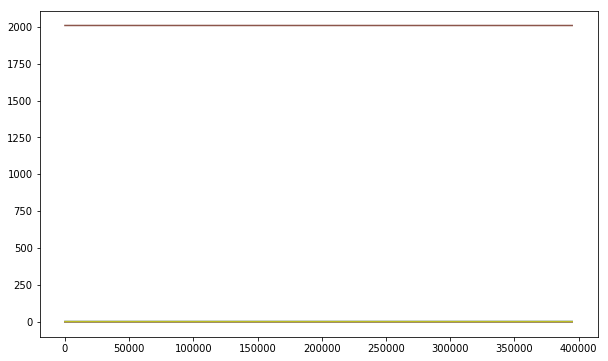

In [71]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
fig = plt.figure(figsize=(10,6))
plt.plot(samples)
plt.show()


True values of the parameters are written out and can be used as the parameters to plot against the data points, but you can also use the values you obtained (currently hard-coded) to produce the solid line that checks to see how close it is to the actual data. The plots are for the three types of data obtained: radial velocity, separation, and position angle.

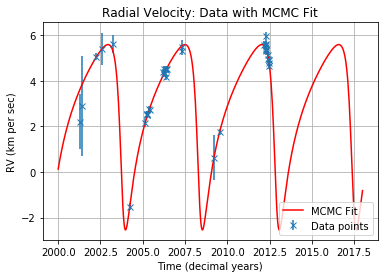

In [82]:
a_tr = 3.07
e_tr = 0.53
inc_tr = 0.94
O_tr = 0.855
w_tr = 2.269
T_0_tr = 2008.4
m_t_tr = 1.39
m_2_tr = 0.29
RV_0_tr = 2.92

true_vals = [a_tr, e_tr, inc_tr, O_tr, w_tr, T_0_tr, m_t_tr, m_2_tr, RV_0_tr]
true_vals_all = np.array((a_tr, e_tr, inc_tr, O_tr, w_tr, T_0_tr, m_t_tr, m_2_tr, RV_0_tr))

my_vals = np.array((3.17, 0.53, 0.98, 0.83, 2.23, 2008.34, 1.54, 0.31, 2.84))
# plotting over continuous time
t_PLT = np.linspace(2000,2018, 500)

# creating all three data sets over time
rv_PLOT = np.zeros(len(t_PLT))
rv_PLOT_est = np.zeros(len(t_PLT))
for i in range(len(t_PLT)):
    rv_PLOT[i] = rv_model(t_PLT[i], true_vals_all)
    rv_PLOT_est[i] = rv_model(t_PLT[i], my_vals)
    
sep_PLOT = np.zeros(len(t_PLT))
sep_PLOT_est = np.zeros(len(t_PLT))

for i in range(len(t_PLT)):
    sep_PLOT[i] = sep_model(t_PLT[i], true_vals_all)
    sep_PLOT_est[i] = sep_model(t_PLT[i], my_vals)
    
pos_PLOT = np.zeros(len(t_PLT))
pos_PLOT_est = np.zeros(len(t_PLT))

for i in range(len(t_PLT)):
    pos_PLOT[i] = pos_model(t_PLT[i], true_vals_all)
    pos_PLOT_est[i] = pos_model(t_PLT[i], my_vals)
    
    
plt.plot(t_PLT, rv_PLOT_est, 'r-', label='MCMC Fit')
plt.errorbar(t_rv, rv_dat, yerr=rv_err, marker='x', linestyle='', label='Data points')

plt.grid(True)
plt.xlabel('Time (decimal years)')
plt.ylabel('RV (km per sec)')
plt.title('Radial Velocity: Data with MCMC Fit')
plt.legend(framealpha=0.8, loc="lower right")
plt.savefig('RV_Plot.png')
plt.show()


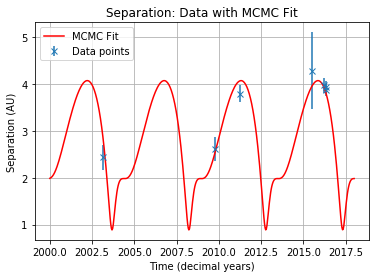

In [83]:
plt.plot(t_PLT, sep_PLOT_est, 'r-', label='MCMC Fit')
plt.errorbar(t_sep, sep_dat, yerr=sep_err, marker='x', linestyle='', label='Data points')

plt.grid(True)
plt.xlabel('Time (decimal years)')
plt.ylabel('Separation (AU)')
plt.title('Separation: Data with MCMC Fit')
plt.legend(framealpha=0.8, loc="upper left")
plt.savefig('Sep_Plot.png')
plt.show()

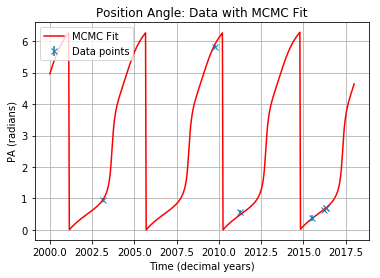

In [84]:
plt.plot(t_PLT, pos_PLOT_est, 'r-', label='MCMC Fit')
# plt.plot(sep_PLOT, pos_PLOT, 'r-', label='Model-generated points')
plt.errorbar(t_pos, pos_dat, yerr=pos_err, marker='x', linestyle='', label='Data points')

plt.grid(True)
plt.xlabel('Time (decimal years)')
plt.ylabel('PA (radians)')
plt.title('Position Angle: Data with MCMC Fit')
plt.legend(framealpha=0.8, loc="upper left")
plt.savefig('PA_Plot.png')
plt.show()

### iii. Results

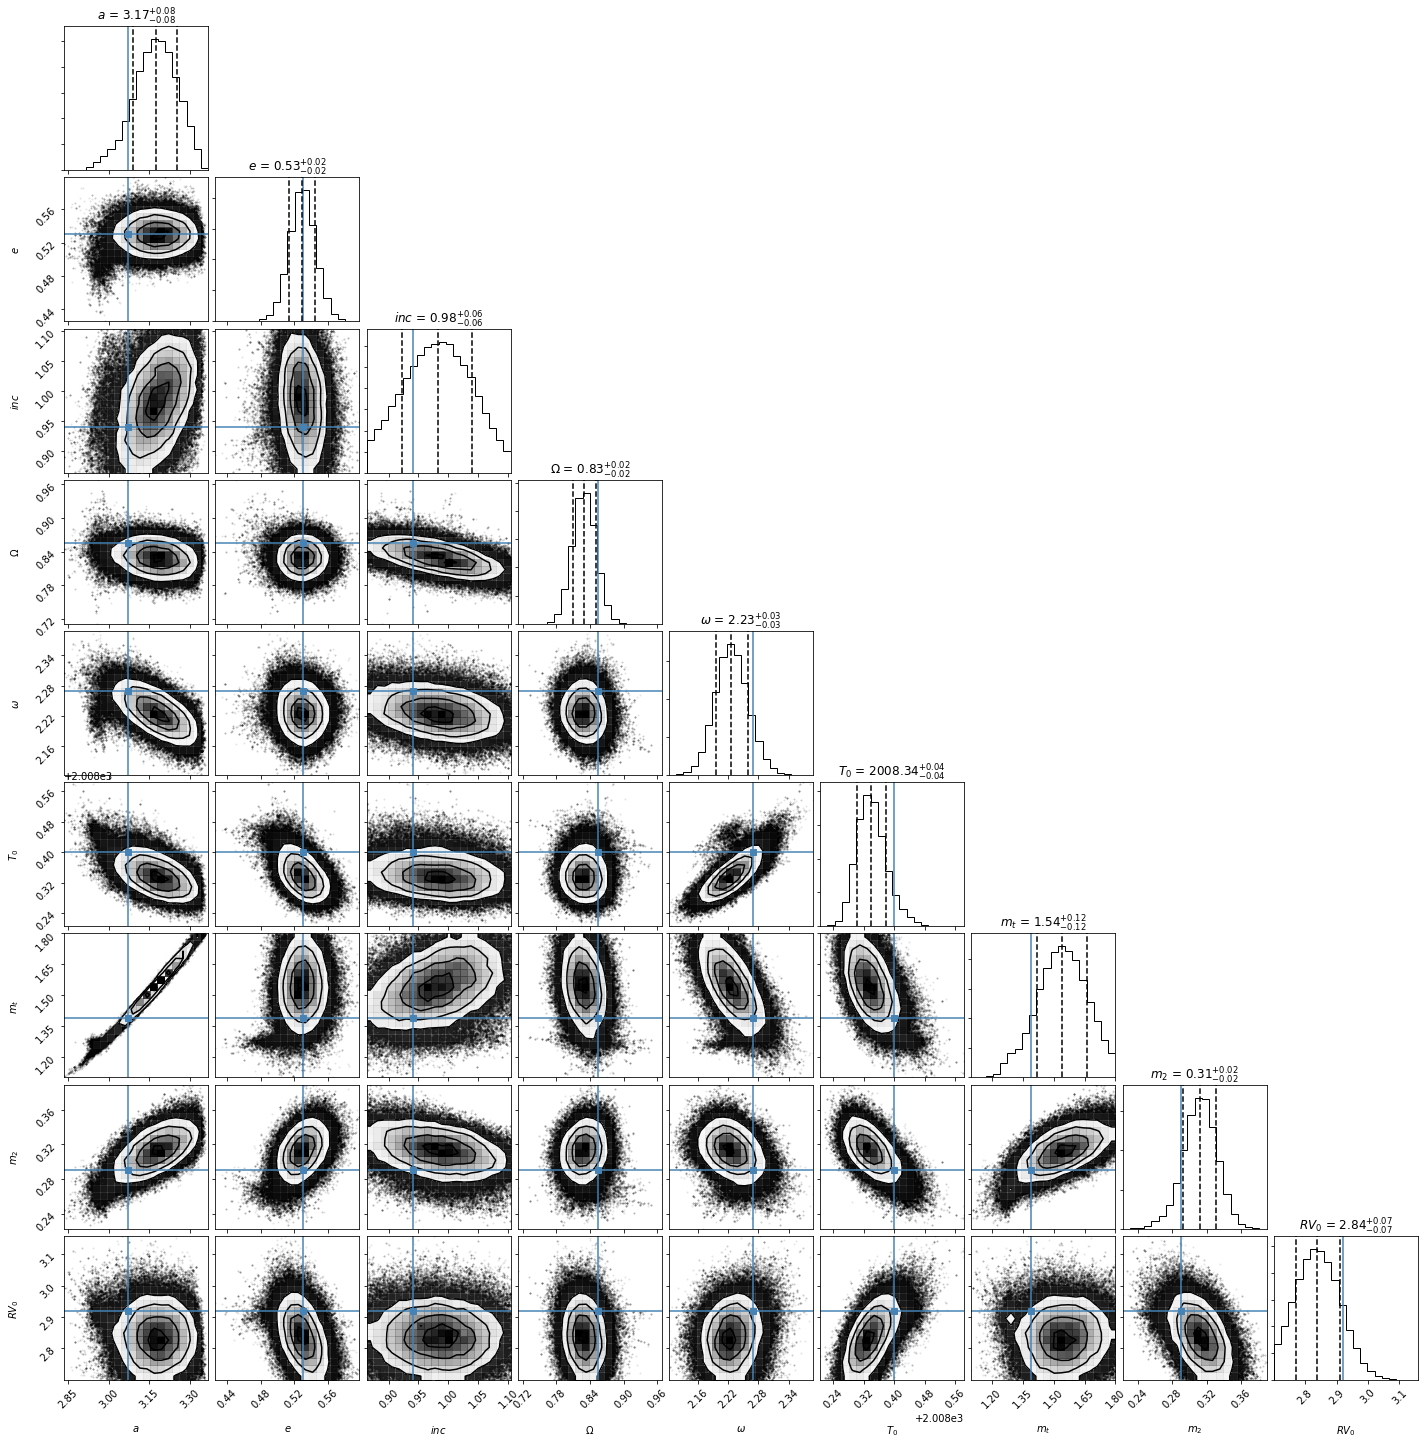

In [78]:
import corner
fig = corner.corner(samples, labels=[r"$a$", r"$e$",r"$inc$", r"$\Omega$", r"$\omega$",\
                                     r"$T_0$", r"$m_t$", r"$m_2$", r"$RV_0$", r"$\Gamma \, [\mathrm{parsec}]$"],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12}, truths=true_vals)
fig.savefig("triangle_9params_3000steps_new.png", dpi=400)
fig.show()